# Calculating observables from images + simple geometric component using SPARCO

In [1]:
from pathlib import Path

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.scipy.interpolate import RegularGridInterpolator
from scipy.special import jn_zeros

from organic._consts import MAS2RAD, RAD2DEG
from organic.data_loader import TrainingImgLoader

%matplotlib widget

## Geometric components

In [2]:
class PointSource(eqx.Module):
    r"""A point source.

    **Attributes**

    - `x`: The $x$-position of the source in $\mathrm{mas}$.
    - `y`: The $y$-position of the source in $\mathrm{mas}$.
    - `sp_idx`: The spectral index $F_lambda \propto \lamba^\mathrm{sp_idx}$
        of the source.

    The attributes can be initialised as either JAX arrays, in which case they are free
    to be optimised, or floats, in which they are considered static."""

    # Required instance attributes.
    x: jax.Array | float
    y: jax.Array | float
    sp_idx: jax.Array | float

    def __init__(
        self,
        *,
        x: jax.Array | float = 0.0,
        y: jax.Array | float = 0.0,
        sp_idx: jax.Array | float = 0.0,
    ) -> None:
        """Mapped directly to class attributes, please see the class docstring."""
        self.x = x
        self.y = y
        self.sp_idx = sp_idx

    def get_complex_visibilities(self, u: jax.Array, v: jax.Array) -> jax.Array:
        r"""Compute complex visibilities.

        **Arguments**

        - `u`: 1D array of $u$-coordinates in the Fourier plane in $\mathrm{rad^{-1}}$.
        - `v`: 1D array of $v$-coordinates in the Fourier plane in $\mathrm{rad^{-1}}$.

        **Returns**

        A complex 1D array holding the complex visibilities calculated at the specified
        $uv$-coordinates.
        """
        vis = jnp.exp(-2j * jnp.pi * (u * self.x + v * self.y))
        return vis

In [3]:
class UD(eqx.Module):
    r"""A uniform dis.

    **Attributes**

    - `x`: The $x$-position of the source in $\mathrm{mas}$.
    - `y`: The $y$-position of the source in $\mathrm{mas}$.
    - `ud`:  The angular uniform disk size in $\mathrm{mas}$.
    - `sp_idx`: The spectral index $F_lambda \propto \lamba^\mathrm{sp_idx}$
        of the source.

    The attributes can be initialised as either JAX arrays, in which case they are free
    to be optimised, or floats, in which they are considered static."""

    # Required instance attributes.
    x: jax.Array | float
    y: jax.Array | float
    ud: jax.Array | float
    sp_idx: jax.Array | float

    def __init__(
        self,
        *,
        x: jax.Array | float = 0.0,
        y: jax.Array | float = 0.0,
        ud: jax.Array | float,
        sp_idx: jax.Array | float = 0.0,
    ) -> None:
        """Mapped directly to class attributes, please see the class docstring."""
        self.x = x
        self.y = y
        self.ud = ud
        self.sp_idx = sp_idx

    def get_complex_visibilities(self, u: jax.Array, v: jax.Array) -> jax.Array:
        r"""Compute complex visibilities.

        **Arguments**

        - `u`: 1D array of $u$-coordinates in the Fourier plane in $\mathrm{rad^{-1}}$.
        - `v`: 1D array of $v$-coordinates in the Fourier plane in $\mathrm{rad^{-1}}$.

        **Returns**

        A complex 1D array holding the complex visibilities calculated at the specified
        $uv$-coordinates.
        """
        # TODO: implement
        raise NotImplementedError

## FFT on a 2D image array

In [ ]:
@jax.jit(static_argnames=["ps", "padding"])
def img_get_complex_visibilities(
    img: jax.Array,
    u: jax.Array,
    v: jax.Array,
    *,
    ps: float,
    padding: tuple[int, int] | None = None,
):
    r"""Uses FFT to calculate complex visibilities for an input 2D image.

    The FFT values are mapped onto the reqauired $uv$-coordinates using bilinear
    interpolation.

    **Arguments**

    - `img`: The 2D input image array.
    - `u`: 1D array of $u$-coordinates in the Fourier plane in $\mathrm{rad^{-1}}$.
    - `v`: 1D array of $u$-coordinates in the Fourier plane in $\mathrm{rad^{-1}}$.
    - `ps`: Pixelscale of the image in $\mathrm{mas / pix}$.
    - `padding`: Amount of pixels to which the image should be zero-padded before
        performing the FFT. I.e. `padding = (1024, 512)` will pad the image to
        1024 and 512 in the $x$ and $y$ direction respectively. Note the padding will
        only be applied in the respective direction if the padded size is larger than
        the original size.

    **Returns**

    A complex 1D array holding the complex visibilities calculated at the specified
    $uv$-coordinates."""

    # Unit conversions: pixelscale in radians for further use.
    ps_rad = ps * MAS2RAD

    # NOTE: take care with the dimension axis convention of numpy versus that of optical
    # interferometry. For numpy, the y direction is the first, the x direction is the
    # second.
    nx, ny = img.shape[1], img.shape[0]  # number of pixels

    if padding is None:
        img_padded = img
    else:
        # NOTE: for uneven amount of padding pixels to be added, the excess pixels will
        # be added at the end of the array axes.
        npad_x = 0 if (padding[0] - nx < 0) else padding[0] - nx
        npad_y = 0 if (padding[1] - ny < 0) else padding[1] - ny

        # Zero-pad the image.
        img_padded = jnp.pad(
            img,
            pad_width=(
                (npad_y // 2, (npad_y // 2) + npad_y % 2),
                (npad_x // 2, (npad_x // 2) + npad_x % 2),
            ),
            mode="constant",
            constant_values=0.0,
        )

    # Perform FFT.

    # Numpy FFT frequencies are in cycles per unit of input spacing.
    # NOTE: pixelscale used is in radian to get spatial frequencies in rad^-1
    nx_padded = img_padded.shape[1]
    ny_padded = img_padded.shape[0]
    u_grid = np.fft.fftshift(np.fft.fftfreq(nx_padded, d=ps_rad))
    v_grid = np.fft.fftshift(np.fft.fftfreq(ny_padded, d=ps_rad))

    # NOTE: due to the numpy conventions (which assumes the phase-center is at the top-
    # left of the image), you must first shift the image in order to get the phase-
    # center to be defined in the middle of the image.
    img_shifted = jnp.fft.ifftshift(img_padded)  # Shift phase center to image center.
    fft_img = jnp.fft.fftshift(
        jnp.fft.fft2(img_shifted)
    )  # Shift frequencies to be centered.

    # NOTE: for the scipy interpolator, JAX has no out-of-bounds error, adding NaNs
    # instead. Before running this function, user should check beforehand if all
    # the uv-points will be covered.
    interpolator = RegularGridInterpolator(
        (v_grid, u_grid),
        fft_img,
    )

    # TODO: implement correction for phase center offset for even amounts of pixels
    # so the phase center is always in the geometric center of the image.

    points = jnp.column_stack((v, u))
    vis = interpolator(points)

    return vis

In [5]:
@jax.jit(static_argnames="ps")
def img_get_sky_coordinates(img: jax.Array, *, ps: float):
    r"""Calculate the interferometric sky coordinates from a 2D image.

    Note that this returns the coordinates of the centers of the pixels, not of the
    edges. The origin point $(x, y) = (0, 0)$ (which is also the phase center of the
    Fourier transform), is located in the geometric center of the image. For an image
    dimension with an even amount of pixels, this means the origin is located on the
    vertex between the two centermost pixel cells.

    **Arguments**

    - `img`: The image to calculate coordinates for. Should be a 2D image.
    - `ps`: The pixelscale of the image in $\mathrm{mas / pix}$.

    **Returns**

    - `x`: A 1D array with the x-coordinates in $\mathrm{mas}$.
    - `y`: A 1D array with the x-coordinates in $\mathrm{mas}$."""

    # NOTE: take care with the dimension axis convention of numpy versus that of optical
    # interferometry. For numpy, the y direction is the first index, the x direction
    # the second.
    nx, ny = img.shape[1], img.shape[0]  # number of pixels

    # Calculate on-sky coordinates of pixel centers.

    # NOTE: take care with the coordinate convention of optical interferometry. The
    # x-coordinate is defined from right to left in the image (from west to east), and
    # the y-coordinate from bottom to top (south to north). The formulation below works
    # for both uneven and even amounts of pixels in either dimension (one can also be
    # even and the other uneven).
    j = jnp.arange(nx)
    i = jnp.arange(ny)

    x = -(j - (nx - 1) / 2) * ps
    y = ((ny - 1) / 2 - i) * ps

    return x, y

In [6]:
def fft_img_get_uv_coordinates(img: jax.Array, ps: float):
    raise NotImplementedError

### Test with example radiative transfer model from training set from `data_loader.ipynb`

In [7]:
directory = """/home/toond/Documents/phd/paper_matisse_imaging/training_data/\
discs_mcfost/runs/ozstar_2zone_cont_training_set/saved_imgs"""

files = sorted(Path(directory).glob("*.npy"))

loader = TrainingImgLoader(
    files,
    batch_size=1,
    normalize=True,
    zoomf=(-0.1, 0.1),
    bkgf=(0.00, 0.10),
    pbkg=0.25,
    blur=0.5,
    rotate=True,
    fliph=True,
    flipv=True,
    read_mode="NUMPY",
    seed=42,
)

# For a generator function, have to zip (which truncates to the shortest of iterables)
# with e.g. a range to limit steps.
nbatch = 1
for step, batch in zip(range(nbatch), loader):
    # NOTE: must map back to the unit interval, since the training loader returns
    # images normalized to the signed unit interval.
    img = jnp.array(
        loader._map_from_unit_signed_to_unit_interval(np.array(batch[0, :, :, 0]))
    )

#### Testing the pixel coordinate calculation

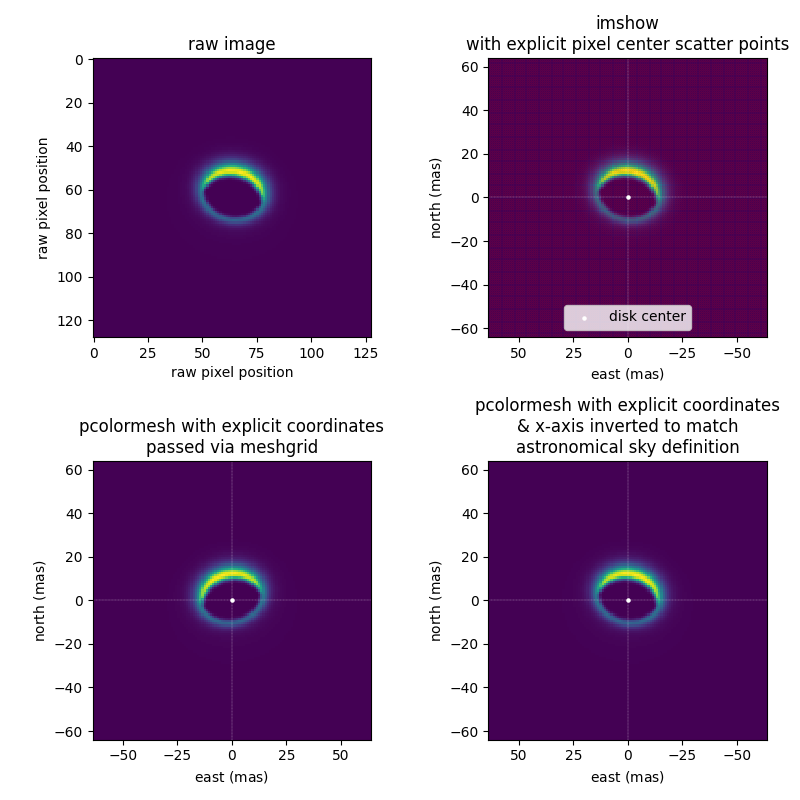

In [8]:
# Pixelscale = 1 for convenience.
ps = 1

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# Get sky coordinates of pixel centers.
x, y = img_get_sky_coordinates(img, ps=ps)
X, Y = jnp.meshgrid(x, y)
ax[0][0].imshow(img, interpolation="none")
ax[0][0].set_xlabel("raw pixel position")
ax[0][0].set_ylabel("raw pixel position")
ax[0][0].set_title("raw image")

# NOTE: when plotting with coordinates, don't forget to flip the x-axis and account for
# an extra half pixelsize to the max/min coordinates (the extent keyword expects the
# edges of the image, not the centers of the edge pixels).
ax[0][1].imshow(
    img,
    interpolation="none",
    extent=[
        jnp.max(x) + ps / 2,
        jnp.min(x) - ps / 2,
        jnp.min(y) - ps / 2,
        jnp.max(y) + ps / 2,
    ],
)
ax[0][1].axvline(x=0, ls="--", lw=0.2, c="w")
ax[0][1].axhline(y=0, ls="--", lw=0.2, c="w")
ax[0][1].scatter(X, Y, c="red", s=0.1, alpha=0.2)
ax[0][1].scatter(0, 0, c="white", s=5, label="disk center")
ax[0][1].set_xlabel(r"east $\mathrm{(mas)}$")
ax[0][1].set_ylabel(r"north $\mathrm{(mas)}$")
ax[0][1].set_title("imshow\nwith explicit pixel center scatter points")
ax[0][1].legend()

ax[1][0].pcolormesh(X, Y, img)
ax[1][0].axvline(x=0, ls="--", lw=0.2, c="w")
ax[1][0].axhline(y=0, ls="--", lw=0.2, c="w")
ax[1][0].scatter(0, 0, c="white", s=5)
ax[1][0].set_aspect("equal")
ax[1][0].set_xlabel(r"east $\mathrm{(mas)}$")
ax[1][0].set_ylabel(r"north $\mathrm{(mas)}$")
ax[1][0].set_title("pcolormesh with explicit coordinates\npassed via meshgrid")

ax[1][1].pcolormesh(X, Y, img)
ax[1][1].axvline(x=0, ls="--", lw=0.2, c="w")
ax[1][1].axhline(y=0, ls="--", lw=0.2, c="w")
ax[1][1].scatter(0, 0, c="white", s=5)
ax[1][1].set_aspect("equal")
ax[1][1].invert_xaxis()
ax[1][1].set_xlabel(r"east $\mathrm{(mas)}$")
ax[1][1].set_ylabel(r"north $\mathrm{(mas)}$")
ax[1][1].set_title(
    "pcolormesh with explicit coordinates\n& x-axis inverted to match\n"
    "astronomical sky definition"
)

plt.tight_layout()
plt.show()

#### Testing application of the FFT

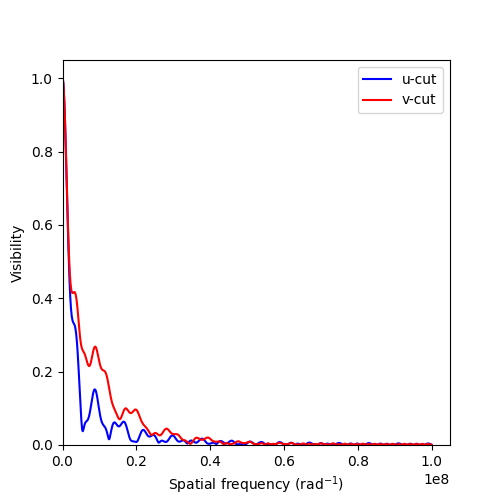

In [9]:
u_ucut = jnp.linspace(0, 100e6, 1000)
v_ucut = jnp.zeros_like(u_ucut)
vis_ucut = img_get_complex_visibilities(
    img, u_ucut, v_ucut, ps=ps, padding=(10_000, 10_000)
)

v_vcut = jnp.linspace(0, 100e6, 1000)
u_vcut = jnp.zeros_like(v_vcut)
vis_vcut = img_get_complex_visibilities(
    img, u_vcut, v_vcut, ps=ps, padding=(10_000, 10_000)
)


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(u_ucut, jnp.abs(vis_ucut) / jnp.sum(img), c="blue", label="u-cut")
ax.plot(v_vcut, jnp.abs(vis_vcut) / jnp.sum(img), c="red", label="v-cut")
ax.set_xlabel(r"Spatial frequency $\mathrm{(rad^{-1})}$")
ax.set_ylabel(r"Visibility")
ax.set_ylim(0)
ax.set_xlim(0)
ax.legend()
plt.show()

### Testing visibility magnitude calculation with thin ring 

#### Some function definitions

In [10]:
def get_thin_ring_null(diam: float, n: int) -> float:
    r"""Compute the spatial frequency corresponding to the nth null of a thin ring'
    visibility profile.<h1>Header Text Continuation text on the same line.</h1>

    **Arguments**

    - `diam`: Outer diameter of the ring in $\mathrm{mas}$.
    - `n`: Number of the null to calculate (i.e. `n=1` gives the first null position).

    **Returns**

    First null spatial frequency in $\mathrm{rad^{-1}}$.
    """
    # Convert outer diameter to radius in radians
    radius_mas = diam / 2
    radius_rad = radius_mas * MAS2RAD  # mas -> arcsec -> deg -> rad

    # nth zero of Bessel J0 function.
    zero_point = jn_zeros(0, n)[n - 1]

    # Spatial frequency in cycles/rad.
    f_rad = zero_point / (2 * np.pi * radius_rad)

    return f_rad


def generate_ring_img(
    npix: int,
    diam: float,
    ps: float,
    width_frac: float,
) -> np.ndarray:
    r"""Generate a 2D image of a thin ring with a given width.

    **Parameters**

    - `npix`: Number of pixels along one axis (image is square).
    - `diam`: Ring outer diameter in $\mathrm{mas}$.
    - `ps`: Pixelscale in $\mathrm{mas / pix}$.
    - `width_frac`: Fraction of the radius for the ring thickness.

    **Returns**

    2D array containing the ring image.
    """
    # Convert diameter to radius in pixels
    radius_pix = (diam / 2) / ps
    width_pix = radius_pix * width_frac

    # Coordinate grids centred at middle of image
    y, x = np.indices((npix, npix)) - npix / 2
    r = np.sqrt(x**2 + y**2)

    # Ring mask: pixels within radius ± half-width
    mask = np.logical_and(
        r >= radius_pix - width_pix / 2, r <= radius_pix + width_pix / 2
    )

    # Create image
    img = np.zeros((npix, npix), dtype=np.float32)
    img[mask] = 1.0  # Set ring intensity

    return img

#### Example image

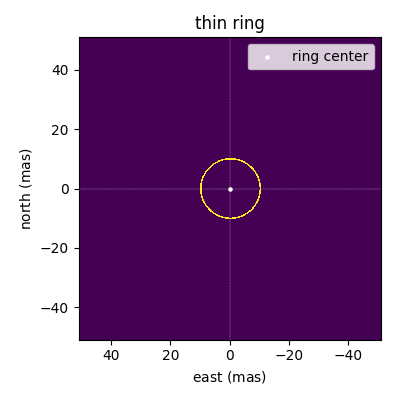

In [11]:
# Example ring.
ps = 0.02
npix = 5096
diam = 20
width_frac = 0.05

img_ring = jnp.array(generate_ring_img(npix=npix, diam=diam, ps=ps, width_frac=0.05))

# Get sky coordinates of pixel centers.
x, y = img_get_sky_coordinates(img_ring, ps=ps)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(
    img_ring,
    interpolation="none",
    extent=(
        (jnp.max(x) + ps / 2).item(),
        (jnp.min(x) - ps / 2).item(),
        (jnp.min(y) - ps / 2).item(),
        (jnp.max(y) + ps / 2).item(),
    ),
)
ax.axvline(x=0, ls="--", lw=0.2, c="w")
ax.axhline(y=0, ls="--", lw=0.2, c="w")
ax.scatter(0, 0, c="white", s=5, label="ring center")
ax.set_title("thin ring")
ax.set_xlabel(r"east $\mathrm{(mas)}$")
ax.set_ylabel(r"north $\mathrm{(mas)}$")
ax.legend()

plt.tight_layout()
plt.show()

#### Example visibility curve with predicted null positions

Predicted null positions should match to high numerical accuracy.

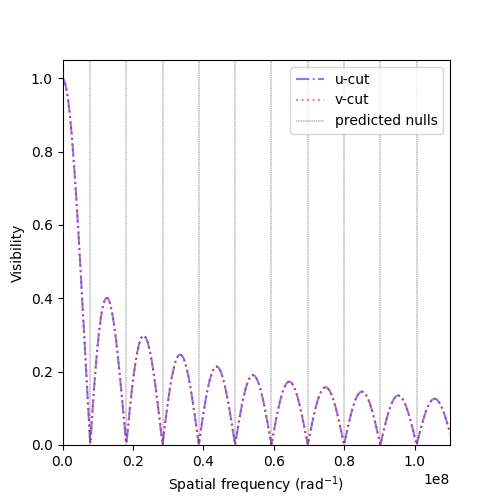

In [12]:
max_spfreq = 110e6  # Maximal spatial frequency.

u_ucut = jnp.linspace(0, max_spfreq, 1000)
v_ucut = jnp.zeros_like(u_ucut)
vis_ucut = img_get_complex_visibilities(
    img_ring, u_ucut, v_ucut, ps=ps, padding=(20_000, 20_000)
)

v_vcut = jnp.linspace(0, max_spfreq, 1000)
u_vcut = jnp.zeros_like(v_vcut)
vis_vcut = img_get_complex_visibilities(
    img_ring, u_vcut, v_vcut, ps=ps, padding=(20_000, 20_000)
)

null_positions = [get_thin_ring_null(diam=diam, n=i + 1) for i in range(10)]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(
    u_ucut,
    jnp.abs(vis_ucut) / jnp.sum(img_ring),
    c="blue",
    label="u-cut",
    alpha=0.5,
    ls="-.",
)
ax.plot(
    v_vcut,
    jnp.abs(vis_vcut) / jnp.sum(img_ring),
    c="red",
    label="v-cut",
    alpha=0.5,
    ls="dotted",
)

# Add predicted null positions.
for i, null in enumerate(null_positions):
    if i == 0:
        ax.axvline(x=null, c="black", ls="--", lw=0.3, label="predicted nulls")
    else:
        ax.axvline(x=null, c="black", ls="--", lw=0.3)

ax.set_xlabel(r"Spatial frequency $\mathrm{(rad^{-1})}$")
ax.set_ylabel(r"Visibility")
ax.set_ylim(0)
ax.set_xlim(0, jnp.max(u_ucut).item())
ax.legend()
plt.show()

### Testing interferometric phase calculation with offset point sources 

#### Central 4 pixels set to 1 value (i.e. mimicking a central star at $(x, y) = (0, 0)$

##### Image with even amount of pixels

In [13]:
npix = 100
ps = 0.01

# Image with only central 4 pixels filled in.
img_central_star = jnp.zeros((npix, npix))
star = jnp.array([[1.0, 1.0], [1.0, 1.0]])  # Sub-image with star.
img_central_star = img_central_star.at[
    (npix // 2) - 1 : (npix // 2) + 1, (npix // 2) - 1 : (npix // 2) + 1
].set(star)  # Insert star into image at central 4 pixels.

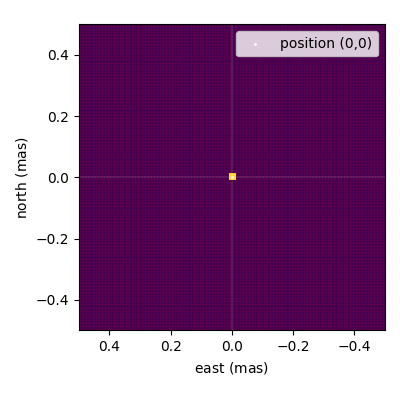

In [14]:
# Get sky coordinates of pixel centers.
x, y = img_get_sky_coordinates(img_central_star, ps=ps)
X, Y = jnp.meshgrid(x, y)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(
    img_central_star,
    interpolation="none",
    extent=(
        (jnp.max(x) + ps / 2).item(),
        (jnp.min(x) - ps / 2).item(),
        (jnp.min(y) - ps / 2).item(),
        (jnp.max(y) + ps / 2).item(),
    ),
)
ax.axvline(x=0, ls="--", lw=0.2, c="w")
ax.axhline(y=0, ls="--", lw=0.2, c="w")
ax.scatter(X, Y, c="red", s=0.1, alpha=0.3)
ax.scatter(0, 0, s=1.0, c="white", label="position (0,0)")
ax.set_xlabel(r"east $\mathrm{(mas)}$")
ax.set_ylabel(r"north $\mathrm{(mas)}$")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

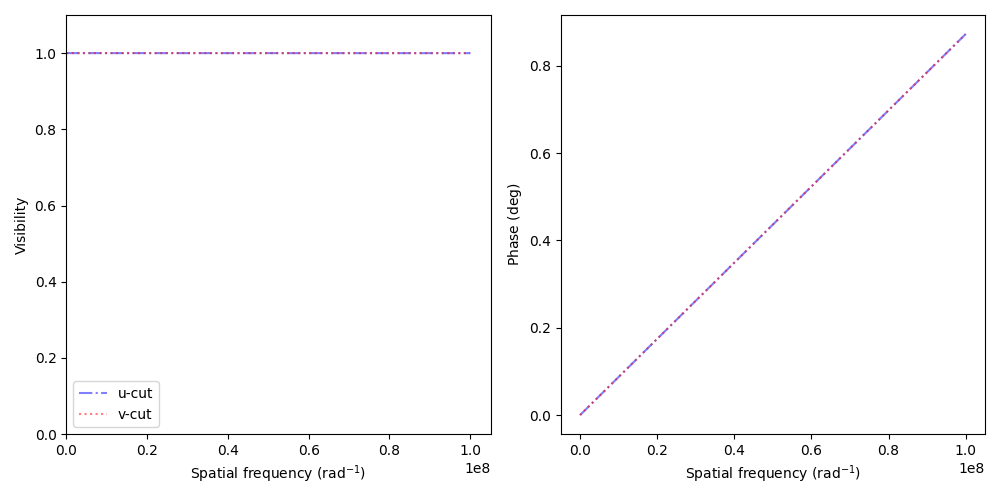

Calculated phase slope is: 8.726629197042257e-09 deg*rad.


In [15]:
u_ucut = jnp.linspace(0, 100e6, 1000)
v_ucut = jnp.zeros_like(u_ucut)
vis_ucut = img_get_complex_visibilities(
    img_central_star, u_ucut, v_ucut, ps=ps, padding=(20_000, 20_000)
)

v_vcut = jnp.linspace(0, 100e6, 1000)
u_vcut = jnp.zeros_like(v_vcut)
vis_vcut = img_get_complex_visibilities(
    img_central_star, u_vcut, v_vcut, ps=ps, padding=(20_000, 20_000)
)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Plot visibility cuts.
ax[0].plot(
    u_ucut,
    jnp.abs(vis_ucut) / jnp.sum(img_central_star),
    c="blue",
    label="u-cut",
    alpha=0.5,
    ls="-.",
)
ax[0].plot(
    v_vcut,
    jnp.abs(vis_vcut) / jnp.sum(img_central_star),
    c="red",
    label="v-cut",
    alpha=0.5,
    ls="dotted",
)
ax[0].set_xlabel(r"Spatial frequency $\mathrm{(rad^{-1})}$")
ax[0].set_ylabel(r"Visibility")
ax[0].set_ylim(0, 1.1)
ax[0].set_xlim(0)
ax[0].legend()

# Plot phase cuts.
ax[1].plot(
    u_ucut,
    jnp.angle(vis_ucut, deg=True),
    c="blue",
    label="u-cut",
    alpha=0.5,
    ls="-.",
)
ax[1].plot(
    v_vcut,
    jnp.angle(vis_vcut, deg=True),
    c="red",
    label="v-cut",
    alpha=0.5,
    ls="dotted",
)
ax[1].set_xlabel(r"Spatial frequency $\mathrm{(rad^{-1})}$")
ax[1].set_ylabel(r"Phase $\mathrm{(deg)}$")

plt.tight_layout()
plt.show()

phase_slope = (jnp.angle(vis_ucut, deg=True)[-1] - jnp.angle(vis_ucut, deg=True)[0]) / (
    u_ucut[-1] - u_ucut[0]
)
print(f"Calculated phase slope is: {phase_slope} deg*rad.")

**NOTE:** we actually measure a non-zero phase slope here. You might think this is a bug
in the source code to calculate complex visibilities but it is not. In fact, it
corresponds to a half-pixel offset in the photocenter relative to the phase center. 
This is due to the way numpy places the phase center when calculating the FFT.

E.g. the
formula for the phase derivative for an offset point in $x$ by $x_p$ along a cut in the
$u$-direction is:

$$d\phi / du = -2 \pi x_p$$

This comes from the formula for the phase of a offset delta function (which we 
approximate here by having only the 4 central pixels in a big image be non-zero):

$$\phi(u,v) = -2 \pi (ux_p + vy_p) $$

Calculating the slope below for a half-pixel offset gives the same numerical result:

In [ ]:
phase_slope_ucut = (-2 * np.pi * (ps / 2) * MAS2RAD) * RAD2DEG
print(f"Calculated phase slope along u-cut: {phase_slope_ucut}")

Calculated phase slope along u-cut: -8.726646259971649e-09


In fact, this effect should disappear if we have a centralised source in an uneven
image.

##### Same, but with image with uneven amount of pixels

In [17]:
npix = 101
ps = 0.01

# Image with only central pixel filled in.
img_central_star = jnp.zeros((npix, npix))
img_central_star = img_central_star.at[npix // 2, npix // 2].set(1.0)

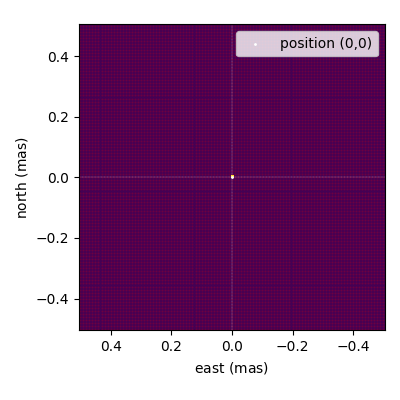

In [18]:
# Get sky coordinates of pixel centers.
x, y = img_get_sky_coordinates(img_central_star, ps=ps)
X, Y = jnp.meshgrid(x, y)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(
    img_central_star,
    interpolation="none",
    extent=(
        (jnp.max(x) + ps / 2).item(),
        (jnp.min(x) - ps / 2).item(),
        (jnp.min(y) - ps / 2).item(),
        (jnp.max(y) + ps / 2).item(),
    ),
)
ax.axvline(x=0, ls="--", lw=0.2, c="w")
ax.axhline(y=0, ls="--", lw=0.2, c="w")
ax.scatter(X, Y, c="red", s=0.3, alpha=0.2)
ax.scatter(0, 0, s=1.0, c="white", label="position (0,0)")
ax.set_xlabel(r"east $\mathrm{(mas)}$")
ax.set_ylabel(r"north $\mathrm{(mas)}$")
ax.legend()

plt.tight_layout()
plt.show()

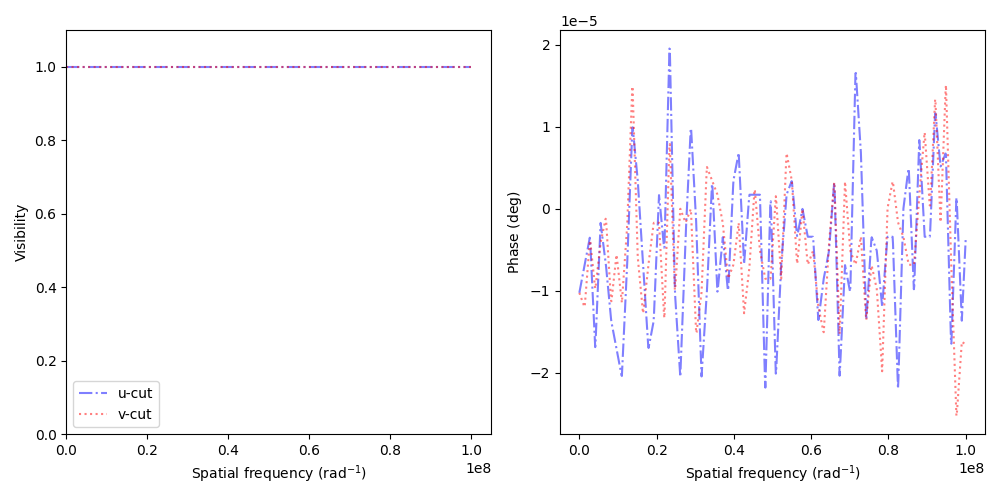

In [19]:
u_ucut = jnp.linspace(0, 100e6, 1000)
v_ucut = jnp.zeros_like(u_ucut)
vis_ucut = img_get_complex_visibilities(
    img_central_star, u_ucut, v_ucut, ps=ps, padding=(15_001, 15_001)
)

v_vcut = jnp.linspace(0, 100e6, 1000)
u_vcut = jnp.zeros_like(v_vcut)
vis_vcut = img_get_complex_visibilities(
    img_central_star, u_vcut, v_vcut, ps=ps, padding=(15_001, 15_001)
)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Plot visibility cuts.
ax[0].plot(
    u_ucut,
    jnp.abs(vis_ucut) / jnp.sum(img_central_star),
    c="blue",
    label="u-cut",
    alpha=0.5,
    ls="-.",
)
ax[0].plot(
    v_vcut,
    jnp.abs(vis_vcut) / jnp.sum(img_central_star),
    c="red",
    label="v-cut",
    alpha=0.5,
    ls="dotted",
)
ax[0].set_xlabel(r"Spatial frequency $\mathrm{(rad^{-1})}$")
ax[0].set_ylabel(r"Visibility")
ax[0].set_ylim(0, 1.1)
ax[0].set_xlim(0)
ax[0].legend()

# Plot phase cuts.
ax[1].plot(
    u_ucut,
    jnp.angle(vis_ucut, deg=True),
    c="blue",
    label="u-cut",
    alpha=0.5,
    ls="-.",
)
ax[1].plot(
    v_vcut,
    jnp.angle(vis_vcut, deg=True),
    c="red",
    label="v-cut",
    alpha=0.5,
    ls="dotted",
)
ax[1].set_xlabel(r"Spatial frequency $\mathrm{(rad^{-1})}$")
ax[1].set_ylabel(r"Phase $\mathrm{(deg)}$")

plt.tight_layout()
plt.show()

And voila, the phase is simply zero up to some numerical noise!

##### Image with even amount of pixels but with star actually centered on the phase center assumed by numpy

In [20]:
npix = 100
ps = 0.01

# Image with only central pixel filled in.
img_central_star = jnp.zeros((npix, npix))
img_central_star = img_central_star.at[npix // 2, npix // 2].set(1.0)

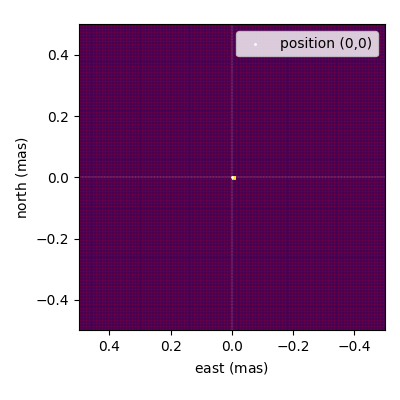

In [21]:
# Get sky coordinates of pixel centers.
x, y = img_get_sky_coordinates(img_central_star, ps=ps)
X, Y = jnp.meshgrid(x, y)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(
    img_central_star,
    interpolation="none",
    extent=(
        (jnp.max(x) + ps / 2).item(),
        (jnp.min(x) - ps / 2).item(),
        (jnp.min(y) - ps / 2).item(),
        (jnp.max(y) + ps / 2).item(),
    ),
)
ax.axvline(x=0, ls="--", lw=0.2, c="w")
ax.axhline(y=0, ls="--", lw=0.2, c="w")
ax.scatter(X, Y, c="red", s=0.3, alpha=0.2)
ax.scatter(0, 0, s=1.0, c="white", label="position (0,0)")
ax.set_xlabel(r"east $\mathrm{(mas)}$")
ax.set_ylabel(r"north $\mathrm{(mas)}$")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

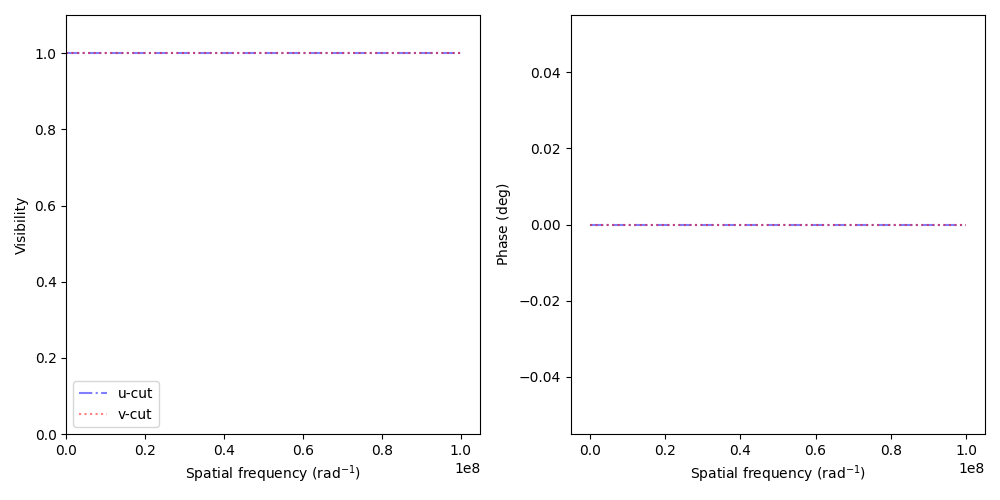

Calculated phase slope is: 0.0 deg*rad.


In [22]:
u_ucut = jnp.linspace(0, 100e6, 1000)
v_ucut = jnp.zeros_like(u_ucut)
vis_ucut = img_get_complex_visibilities(
    img_central_star, u_ucut, v_ucut, ps=ps, padding=(20_000, 20_000)
)

v_vcut = jnp.linspace(0, 100e6, 1000)
u_vcut = jnp.zeros_like(v_vcut)
vis_vcut = img_get_complex_visibilities(
    img_central_star, u_vcut, v_vcut, ps=ps, padding=(20_000, 20_000)
)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Plot visibility cuts.
ax[0].plot(
    u_ucut,
    jnp.abs(vis_ucut) / jnp.sum(img_central_star),
    c="blue",
    label="u-cut",
    alpha=0.5,
    ls="-.",
)
ax[0].plot(
    v_vcut,
    jnp.abs(vis_vcut) / jnp.sum(img_central_star),
    c="red",
    label="v-cut",
    alpha=0.5,
    ls="dotted",
)
ax[0].set_xlabel(r"Spatial frequency $\mathrm{(rad^{-1})}$")
ax[0].set_ylabel(r"Visibility")
ax[0].set_ylim(0, 1.1)
ax[0].set_xlim(0)
ax[0].legend()

# Plot phase cuts.
ax[1].plot(
    u_ucut,
    jnp.angle(vis_ucut, deg=True),
    c="blue",
    label="u-cut",
    alpha=0.5,
    ls="-.",
)
ax[1].plot(
    v_vcut,
    jnp.angle(vis_vcut, deg=True),
    c="red",
    label="v-cut",
    alpha=0.5,
    ls="dotted",
)
ax[1].set_xlabel(r"Spatial frequency $\mathrm{(rad^{-1})}$")
ax[1].set_ylabel(r"Phase $\mathrm{(deg)}$")

plt.tight_layout()
plt.show()

phase_slope = (jnp.angle(vis_ucut, deg=True)[-1] - jnp.angle(vis_ucut, deg=True)[0]) / (
    u_ucut[-1] - u_ucut[0]
)
print(f"Calculated phase slope is: {phase_slope} deg*rad.")

**NOTE:** This matches expectations for a centered source (less noise as well because 
it's in this case with an even amount of pixels), hence we see that numpy places the
the phase reference center not exactly in the middle of the image. The true image
center if you assume the FOV is distributed symetrically (length to edge of FOV on left
and right) is on a vertex of a cell (i.e. on its boundary). However, numpy ifftshift
switches the quadrants of the image, where the phase center is originally at $(0,0)$,
but that's in pixel coordinates, i.e. the center of the top-left pixel!
When the quadrants are switched the phase center is thus still in the middle of a pixel,
hence the phase center is half a pixel to the right and bottom of where you would expect
it to be with a symmetric FOV!

## Application to ORGANIC reconstruction of IRAS 08544-4431 with given SPARCO model